# Breast cancer case

In [1]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import f_classif
from scipy.stats import pointbiserialr

import matplotlib.pyplot as plt

from functions import crossvalidation_as_framework, random_forest_benchmark, lasso_benchmark, gradient_boosting_benchmark, elasticnet_benchmark
from seaborn import clustermap

### Load and prep data

In [2]:
data = pd.read_csv('../data/brca_data_w_meta.csv')

In [3]:
# Define the target variable
target = "vital.status"

In [4]:
stypes = {}
for f in data.columns:
    if data[f].dtype == 'object':
        stypes[f] = 'c'

In [5]:
data[target].value_counts()

0    611
1     94
Name: vital.status, dtype: int64

### 2 feature models

In [6]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 50,
                                     criterion='bic',
                                     max_complexity = 3)

In [7]:
results.groupby("fold").first().roc_auc_val.mean(), results.groupby("fold").first().roc_auc_val.std()

(0.6382296594032952, 0.07407253074513537)

In [8]:
results.groupby("fold").first().roc_auc_train.mean(), results.groupby("fold").first().roc_auc_train.std()

(0.6712429863379155, 0.03333248504486059)

In [9]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(rsCHST9*rsPCK1),647.344838,656.014947,0.665417,0.757092,0.659440,0.730496,0.346362,0.235294,"multiply(""rs_PCK1"", ""rs_CHST9"")"
1,logreg(rsAPOB*rsGPM6A),634.402481,643.072589,0.722427,0.773050,0.588870,0.737589,0.209888,0.232258,"multiply(""rs_GPM6A"", ""rs_APOB"")"
2,logreg(exp(-rsLOC283392**2 - rsOXTR**2)),635.943571,653.283788,0.665003,0.868794,0.537964,0.836879,0.226175,0.236842,"gaussian(""rs_LOC283392"", ""rs_OXTR"")"
3,logreg(exp(-rsMRAP**2 - rsOXTR**2)),660.672829,678.013046,0.629475,0.858156,0.682916,0.879433,0.437718,0.246753,"gaussian(""rs_OXTR"", ""rs_MRAP"")"
4,logreg(rsAPOB*rsSLC28A3),666.334833,675.004942,0.673892,0.806738,0.721959,0.808511,0.446573,0.245161,"multiply(""rs_SLC28A3"", ""rs_APOB"")"


In [10]:
for model in results.groupby("fold").first()['model_structure']:
    print(model)

logreg(rsCHST9*rsPCK1)
logreg(rsAPOB*rsGPM6A)
logreg(exp(-rsLOC283392**2 - rsOXTR**2))
logreg(exp(-rsMRAP**2 - rsOXTR**2))
logreg(rsAPOB*rsSLC28A3)


#### Exploration of best models

In [11]:
ql = feyn.connect_qlattice()

A new community QLattice has been allocated for you. This temporary QLattice is available for personal/non-commercial use. By using this community QLattice you agree to the terms and conditions which can be found at `https://abzu.ai/privacy`.


In [12]:
best_models_qstrings = results.groupby("fold").first()['query_string'].values

n_folds = 5
random_state = 42
models_trained = []
train_list = []
val_list = []

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
for i, (train, val) in enumerate(kfold_test.split(data, data[target])):
        train, val = data.iloc[train], data.iloc[val]
        train_list.append(train)
        val_list.append(val)
        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        ql.reset(random_state)
        model = ql.auto_run(train, output_name=target, n_epochs=20, kind = "classification",
                             query_string=best_models_qstrings[i], sample_weights=sample_weights, stypes=stypes)[0]
        models_trained.append(model)

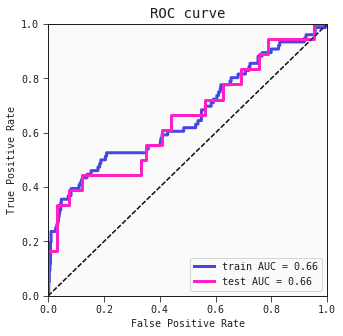

In [13]:
models_trained[0].plot_roc_curve(train_list[0], label='train', figsize=(5,5))
models_trained[0].plot_roc_curve(val_list[0], label='test', ax=plt.gca(), figsize=(5,5))
plt.savefig('../figures/bc_mc3_roc_auc'+'.pdf', dpi=300, bbox_inches='tight')

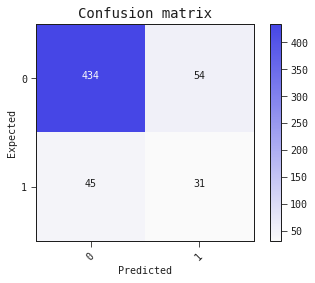

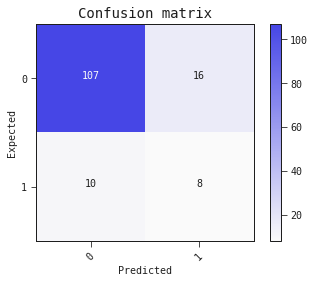

In [14]:
models_trained[0].plot_confusion_matrix(train_list[0], filename = '../figures/bc_mc3_confusion_train.pdf')
models_trained[0].plot_confusion_matrix(val_list[0], filename='../figures/bc_mc3_confusion_test.pdf')

**List of inputs**

In [15]:
inputs_list = []
for m in models_trained:
    for i in m.inputs:
        inputs_list.append(i)
        
inputs_list = list(set(inputs_list))

##### **Clustermap**

In [16]:
corr_inputs = data[inputs_list].corr()

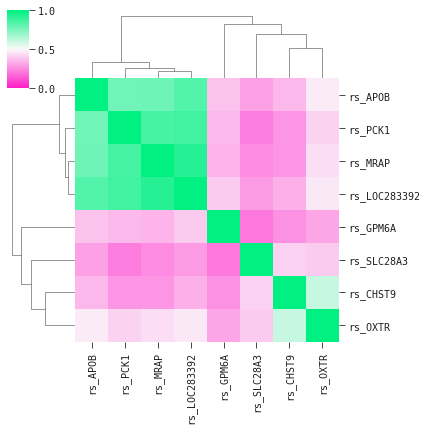

In [17]:
cluster_map_args = {'cmap': 'feyn-diverging', 'vmin': 0, 'vmax': 1}

clustermap(abs(corr_inputs), **cluster_map_args, figsize=(6, 6))
plt.savefig('../figures/bc_multi_clustermap.pdf', dpi=300, bbox_inches='tight')

In [18]:
data[inputs_list].corr()['rs_APOB'].sort_values(ascending=False)

rs_APOB         1.000000
rs_LOC283392    0.835160
rs_MRAP         0.780383
rs_PCK1         0.773892
rs_OXTR         0.466882
rs_GPM6A        0.372880
rs_CHST9        0.349093
rs_SLC28A3      0.299441
Name: rs_APOB, dtype: float64

Pairwise Pearson correlation within the main group in the heatmap above varies from ~0.77 to ~0.84

##### **Pearson correlation with output `vital.status`**

In [19]:
data_corr = list()
for inp in inputs_list:
    res = pointbiserialr(data[inp], data[target])
    data_corr.append([round(res.correlation, 3), res.pvalue])

df_corr = pd.DataFrame(columns=['Pearson corr.', 'p_value'], data=data_corr, index=inputs_list)
df_corr['p_value adj.'] = (df_corr['p_value']*data.shape[1])
df_corr.loc[df_corr['p_value adj.']>1, 'p_value adj.']=1
df_corr.sort_values(by='p_value adj.')

,Pearson corr.,p_value,p_value adj.
rs_APOB,0.270,3.064640e-13,5.939273e-10
rs_LOC283392,0.230,6.270326e-10,1.215189e-06
rs_PCK1,0.225,1.631734e-09,3.162301e-06
rs_MRAP,0.214,9.956550e-09,1.929579e-05
rs_OXTR,0.194,1.971209e-07,3.820204e-04
rs_CHST9,0.139,2.211530e-04,4.285945e-01
rs_GPM6A,0.116,1.970484e-03,1.000000e+00
rs_SLC28A3,0.099,8.730694e-03,1.000000e+00


In [20]:
print(df_corr.sort_values(by='p_value').to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Pearson corr. &       p\_value &  p\_value adj. \\
\midrule
rs\_APOB      &          0.270 &  3.064640e-13 &  5.939273e-10 \\
rs\_LOC283392 &          0.230 &  6.270326e-10 &  1.215189e-06 \\
rs\_PCK1      &          0.225 &  1.631734e-09 &  3.162301e-06 \\
rs\_MRAP      &          0.214 &  9.956550e-09 &  1.929579e-05 \\
rs\_OXTR      &          0.194 &  1.971209e-07 &  3.820204e-04 \\
rs\_CHST9     &          0.139 &  2.211530e-04 &  4.285945e-01 \\
rs\_GPM6A     &          0.116 &  1.970484e-03 &  1.000000e+00 \\
rs\_SLC28A3   &          0.099 &  8.730694e-03 &  1.000000e+00 \\
\bottomrule
\end{tabular}



##### **Model response (3 examples)**

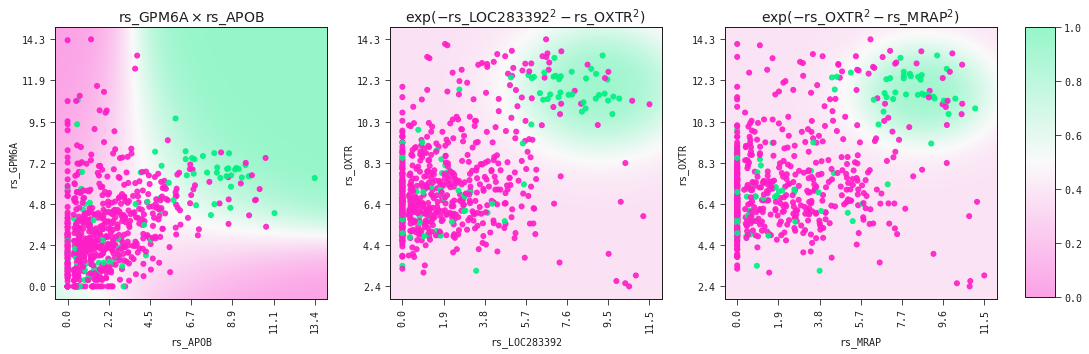

In [21]:
me0, me1, me2 = [1, 2, 3]  # 3 models chosen to be plotted

titles = [
    r'$\mathrm{rs\_GPM6A} \times \mathrm{rs\_APOB}$',
    r'$\exp(-\mathrm{rs\_LOC283392}^2 - \mathrm{rs\_OXTR}^2)$',
    r'$\exp(-\mathrm{rs\_OXTR}^2 - \mathrm{rs\_MRAP}^2)$'
]

fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for i, m in enumerate([models_trained[me0], models_trained[me1], models_trained[me2]]):
    m.plot_response_2d(data, ax=axs[i])
    axs[i].set_title(titles[i])

img = axs[i].get_images()[0]
cax = fig.add_axes([0.92, 0.13, 0.025, 0.75])
fig.colorbar(img, cax=cax)
plt.savefig('../figures/bc_multi_2features_models_response2d.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Larger models

#### Default: `max_complexity = 10`

In [22]:
results10 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     max_complexity=10,
                                     criterion='bic')

In [23]:
results10.groupby("fold").first().roc_auc_val.mean(), results10.groupby("fold").first().roc_auc_val.std()

(0.6332193048706444, 0.04136462826891378)

In [24]:
results10.groupby("fold").first().roc_auc_train.mean(), results10.groupby("fold").first().roc_auc_train.std()

(0.7651063371892302, 0.033119693381080284)

In [25]:
results10.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1,query_string
fold,,,,,,,,,,
0,logreg(tanh(cnGBP5 + cnMIA + muDNHD1 + rsAPOB*...,599.632874,625.643200,0.729117,0.831560,0.625113,0.765957,0.258446,0.219178,"tanh(add(multiply(""rs_APOB"", ""rs_ROPN1""), add(..."
1,logreg(rsPSCA*(cnMYEOV + rsAPOB*(rsFGFBP1 + rs...,595.664316,621.674641,0.790593,0.744681,0.691544,0.695035,0.263879,0.243590,"multiply(add(""cn_MYEOV"", multiply(add(""rs_SLC4..."
2,logreg(rsAPOB*rsHEPACAM2 + tanh(cnKANK4 + rsCA...,601.504160,627.514486,0.807880,0.730496,0.617774,0.666667,0.334514,0.220779,"add(multiply(""rs_HEPACAM2"", ""rs_APOB""), tanh(a..."
3,logreg(cnADCYAP1 + cnSERPINA1 + rsAPOB + rsERE...,625.727153,643.067370,0.755774,0.732270,0.580242,0.687943,0.225003,0.216216,"add(add(""rs_SOX2"", add(add(""cn_SERPINA1"", ""rs_..."
4,logreg(rsFOSB*(cnACSM1*rsAPOB + ppFASN + rsTRP...,618.770019,644.780344,0.742168,0.804965,0.651424,0.780142,0.376497,0.248175,"multiply(""rs_FOSB"", add(multiply(""cn_ACSM1"", ""..."


In [26]:
for model in results10.groupby("fold").first().model_structure:
    print(model)

logreg(tanh(cnGBP5 + cnMIA + muDNHD1 + rsAPOB*rsROPN1))
logreg(rsPSCA*(cnMYEOV + rsAPOB*(rsFGFBP1 + rsSLC44A4)))
logreg(rsAPOB*rsHEPACAM2 + tanh(cnKANK4 + rsCAPN8**2))
logreg(cnADCYAP1 + cnSERPINA1 + rsAPOB + rsEREG + rsSOX2)
logreg(rsFOSB*(cnACSM1*rsAPOB + ppFASN + rsTRPV6))


In [27]:
best_models_qstr_res10 = results10.groupby("fold").first()['query_string'].values

models_default = []

for i, (train, val) in enumerate(zip(train_list, val_list)):        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        ql.reset(random_state)
        models = ql.auto_run(train, output_name=target, n_epochs=20, kind = "classification",
                             query_string=best_models_qstr_res10[i], sample_weights=sample_weights, stypes=stypes)
        models_default.append(models[0])

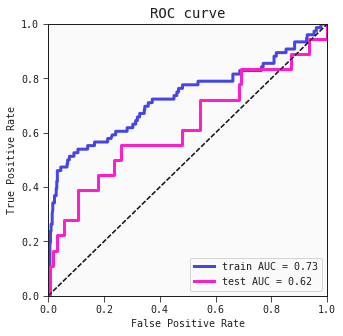

In [28]:
models_default[0].plot_roc_curve(train_list[0], label='train', figsize=(5,5))
models_default[0].plot_roc_curve(val_list[0], label='test', ax=plt.gca(), figsize=(5,5))
plt.savefig('../figures/bc_mc10_roc_auc'+'.pdf', dpi=300, bbox_inches='tight')

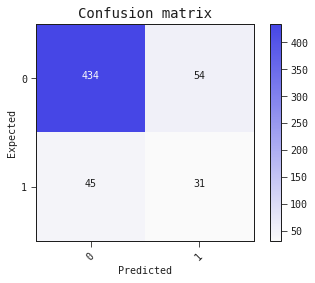

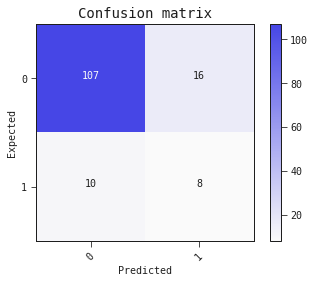

In [29]:
models_trained[0].plot_confusion_matrix(train_list[0], filename = '../figures/bc_mc10_confusion_train.pdf')
models_trained[0].plot_confusion_matrix(val_list[0], filename='../figures/bc_mc10_confusion_test.pdf')

## Benchmarks 

### LASSO

In [30]:
results_lasso = lasso_benchmark(data, target, num_experiments=1, n_jobs=50)

In [31]:
results_lasso

array([0.4936766 , 0.5608283 , 0.62942192, 0.4866264 , 0.67083693])

In [32]:
np.mean(results_lasso)

0.5682780299186369

### Random forest

#### No feature selection

In [33]:
results_rf = random_forest_benchmark(data, target, n_jobs=50)

In [34]:
results_rf

array([0.58175248, 0.61820535, 0.65358067, 0.57808456, 0.58930112])

In [35]:
results_rf.mean()

0.6041848367865329

#### Feature selection by mutual information (top 10)

In [36]:
results_rf_mi = random_forest_benchmark(data, target, feat_selection='mi', n_jobs=50)

In [37]:
results_rf_mi

array([0.62240289, 0.60094909, 0.67083693, 0.64301122, 0.60483175])

In [38]:
results_rf_mi.mean()

0.6284063762409267

#### Feature selection by mutual information (top 5)

In [39]:
results_rf_mi_top5 = random_forest_benchmark(data, target, feat_selection='mi', n_jobs=50, k=5)

In [40]:
results_rf_mi_top5

array([0.5532972 , 0.5742019 , 0.62489215, 0.63718723, 0.5811044 ])

In [41]:
results_rf_mi_top5.mean()

0.5941365753893374

#### Feature selection by f_score (top 10)

In [42]:
results_rf_f = random_forest_benchmark(data, target, feat_selection='f_score', n_jobs=50)

In [43]:
results_rf_f

array([0.55826558, 0.55349439, 0.54918033, 0.49223469, 0.63589301])

In [44]:
results_rf_f.mean()

0.5578135997063163

#### Feature selection by f_score (top 5)

In [45]:
results_rf_f_top5 = random_forest_benchmark(data, target, feat_selection='f_score', n_jobs=50, k=5)

In [46]:
results_rf_f_top5

array([0.51174345, 0.59555651, 0.57851596, 0.46850733, 0.55176877])

In [47]:
results_rf_f_top5.mean()

0.5412184054253542

#### Feature selection by lasso

In [48]:
results_rf_l = random_forest_benchmark(data, target, feat_selection='lasso', n_jobs=50)

In [49]:
results_rf_l

array([0.56187895, 0.68075928, 0.71484038, 0.49482312, 0.56902502])

In [50]:
results_rf_l.mean()

0.6042653503900584

### Gradient Boosting

#### No feature selection

In [51]:
results_gb = gradient_boosting_benchmark(data, target)

In [52]:
results_gb

array([0.5171635 , 0.70880069, 0.62122519, 0.45987921, 0.54184642])

In [53]:
results_gb.mean()

0.5697830029781461

#### Feature selection by mutual information top 10

In [54]:
results_gb_mi = gradient_boosting_benchmark(data, target, feat_selection='mi', n_jobs=50)

In [55]:
results_gb_mi

array([0.51851852, 0.62251941, 0.65875755, 0.67903365, 0.62467645])

In [56]:
results_gb_mi.mean()

0.6207011152653947

#### Feature selection by mutual information top 5

In [57]:
results_gb_mi_top5 = gradient_boosting_benchmark(data, target, feat_selection='mi', n_jobs=50, k=5)

In [58]:
results_gb_mi_top5

array([0.54968383, 0.61302847, 0.6015962 , 0.65789474, 0.53235548])

In [59]:
results_gb_mi_top5.mean()

0.5909117444640077

#### Feature selection by f_score top 10

In [60]:
results_gb_f = gradient_boosting_benchmark(data, target, feat_selection='f_score', n_jobs=50)

In [61]:
results_gb_f

array([0.45889792, 0.57981018, 0.60224331, 0.43787748, 0.62661777])

In [62]:
results_gb_f.mean()

0.541089334246808

#### Feature selection by f_score top 5

In [63]:
results_gb_f_top5 = gradient_boosting_benchmark(data, target, feat_selection='f_score', n_jobs=50, k=5)

In [64]:
results_gb_f_top5

array([0.50022584, 0.71872304, 0.68636756, 0.45858499, 0.5877912 ])

In [65]:
results_gb_f.mean()

0.541089334246808

#### Feature selection by lasso

In [66]:
results_gb_l = gradient_boosting_benchmark(data, target, feat_selection='lasso', n_jobs=50)

In [67]:
results_gb_l

array([0.60275519, 0.66048318, 0.62036238, 0.52415876, 0.56298533])

In [68]:
results_gb_l.mean()

0.5941489680930746

### Elastic net

In [69]:
results_en = elasticnet_benchmark(data, target, num_experiments=1)

/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/jupyter-miquel.iglesias/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [70]:
results_en

array([0.55600723, 0.5880069 , 0.64322692, 0.60008628, 0.66695427])

In [71]:
np.mean(results_en)

0.6108563202399353

## Summary table

In [78]:
data = [[results10.groupby("fold").first().roc_auc_val.mean(), None, None, None, None, None],
        [np.mean(results_lasso), None, None, None, None, None],
        [np.mean(results_en), None, None, None, None, None],
        [np.mean(results_rf), np.mean(results_rf_mi), np.mean(results_rf_f), 
         np.mean(results_rf_mi_top5),np.mean(results_rf_f_top5), np.mean(results_rf_l)],
        [np.mean(results_gb), np.mean(results_gb_mi), np.mean(results_gb_f),
         np.mean(results_gb_mi_top5), np.mean(results_gb_f_top5), np.mean(results_gb_l)]
       ]
df_bench = pd.DataFrame(data=data,
             index=["QLattice", "LASSO", "Elasticnet", "Random Forest", "Gradient Boosting"],
             columns=["All features", "MI top 10", "F top 10", 
                      "MI top 5", "F top 5", "LASSO Features"])
df_bench.round(3).replace(np.nan, "-")

,All features,MI top 10,F top 10,MI top 5,F top 5,LASSO Features
QLattice,0.633,-,-,-,-,-
LASSO,0.568,-,-,-,-,-
Elasticnet,0.611,-,-,-,-,-
Random Forest,0.604,0.628,0.558,0.594,0.541,0.604
Gradient Boosting,0.570,0.621,0.541,0.591,0.59,0.594


In [79]:
print(df_bench.round(3).replace(np.nan, "-").to_latex())

\begin{tabular}{lrlllll}
\toprule
{} &  All features & MI top 10 & F top 10 & MI top 5 & F top 5 & LASSO Features \\
\midrule
QLattice          &         0.633 &         - &        - &        - &       - &              - \\
LASSO             &         0.568 &         - &        - &        - &       - &              - \\
Elasticnet        &         0.611 &         - &        - &        - &       - &              - \\
Random Forest     &         0.604 &     0.628 &    0.558 &    0.594 &   0.541 &          0.604 \\
Gradient Boosting &         0.570 &     0.621 &    0.541 &    0.591 &    0.59 &          0.594 \\
\bottomrule
\end{tabular}

